# The purpose of this note book is to demo some tools for model evaluation


In [5]:
import sys
import pandas as pd
import numpy as np


# data modules, just for demos
sys.path.append('/home/jovyan/workspace/SAP/mock_data')
import load_ppa_data
ppa_symbols_data = load_ppa_data.data_loader_ppa()

# metric modules
sys.path.append('/home/jovyan/workspace/SAP/metrics/')
import gini as robin_williams 
import ks
from ppa_metrics import quick_mse, quick_mae

# exhibit modules
sys.path.append('/home/jovyan/workspace/SAP/exhibits')
import lorenz_curve as lrz
import lift_bar_chart as lift 


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)


data = {'LRR': [0.6, 0.8, 1.0, 1.2, 1.4],
        'loss': [x/5 for x in [0.6, 0.8, 1.0, 1.2, 1.4]],
        'weight': [0.2] * 5  # Repeats 0.2 five times
        }
mock_data_1 = pd.DataFrame(data)

data_2 = {'LRR': [0.6, 0.8, 1.0, 1.2, 1.4]* 5,
          'weight': [0.04] * 25,  # Repeats 0.2 five times
          'score': ['a', 'b', 'c', 'd', 'e'] *5
         }

mock_data_2 = pd.DataFrame(data_2)


## Performance metrics and exhibits



### quick mae/quick mse

The ppa team often uses this as a metric to measure how much a loss ratio relativity varies on a coarse grouping. By default it is not advised to use this if the granularity level is fine. In this specfic case, having a higher MSE/MAE is better, though this is not the standard use case. 

In [6]:
print(mock_data_1)

print('For use with pregrouped data')
quick_mae(mock_data_1['LRR'], mock_data_1['weight'])
quick_mse(mock_data_1['LRR'], mock_data_1['weight'])

print('For use with grouped data')

print(mock_data_2.head())
quick_mae(mock_data_2['LRR'], mock_data_2['weight'], mock_data_2['score'])
quick_mse(mock_data_2['LRR'], mock_data_2['weight'], mock_data_2['score'])

   LRR  loss  weight
0  0.6  0.12     0.2
1  0.8  0.16     0.2
2  1.0  0.20     0.2
3  1.2  0.24     0.2
4  1.4  0.28     0.2
For use with pregrouped data
0.23999999999999994
0.07999999999999999
For use with grouped data
   LRR  weight score
0  0.6    0.04     a
1  0.8    0.04     b
2  1.0    0.04     c
3  1.2    0.04     d
4  1.4    0.04     e
0.23999999999999994
0.07999999999999996


## Gini
Model comparison using lorenz curves
Lorenz curves (or gini) provide graphical (or statistical) method that is not reliant on any technical assumptions, to measure how well ordered data is. Originally developed to measure wealth inequality, a higher gini index for wealth means a less even distribution. Here are some real numbers as of the date of writing according to the CIA:

* South Africa 63%
* Singapore 45.9%
* Micronesia 40.1%
* USA: 39.8%
* Morocco: 39.5%
* Finland: 27.1%
* Belarus 24.4% 

Note: gini measures inequality in wealth (or risk), not wealth (or risk) absolutely. These numbers make sense when you think about how wealthy the rich are compared to the poor. The 85-88k USD per year salaries of US and Singapore makes the typical citizen of those countries much better off than Belarus with its 6k average salary, even if the later has lower wealth inequality.

For insurance, differentiating between high risk and low risk policies is one of the two primary goals of a model, as doing so avoids adverse selection, and makes us more competitive across the board. Gini does not show rate adequacy, but rather good differentiation: rate adequacy has to be shown through different means.

### Using gini:

With Gini one can compare two models. As Gini is a small percent, and its size varies, the easiest way to compare two models is to take the ratio of the overall gini. In this sense,
* A major improvement in a model would be a 15% gini improvement (as a ratio). This would be akin to being the first company to use credit
* A better similar model, might have a 1% gini improvement


In [3]:
robin_williams.gini(ppa_symbols_data['symbol_fct_2024'], ppa_symbols_data['loss_cap100k'],  weight = ppa_symbols_data['adjecd_100k_xsym_norm'] )

0.12429608677853243

## KS-Kolmogorov Smirnoff Statistic 

 A closely related statistic is the Kolmogorov Smirnoff Statistic, which finds the maximum seperation between loss and  weight (in this version). KS will typically be a bit less than gini. 

In [4]:
ks.ks_statistic(ppa_symbols_data['symbol_fct_2024'], ppa_symbols_data['loss_cap100k'],  weight = ppa_symbols_data['adjecd_100k_xsym_norm'])

0.08715555750500609

## Lorenz curves:

Whereas, gini is a simple number, a statistic, a Lorenz curve shows the realtionship, to how much loss is associated with how much exposure. While harder to read for a non-technical audience, a lot more information is present on a Lorenz curve, e.g. one can see how much loss is owned by the worst 1% of drivers. Additionally, gini is twice the area between the curve and the line y = x, while KS is the maximum seperation between the Lorenz curve and y = x. Twice the area formed by the triangle with points, (0,0), (1,1) and the largest seperation, is also KS which gives the relationship between gini and KS.


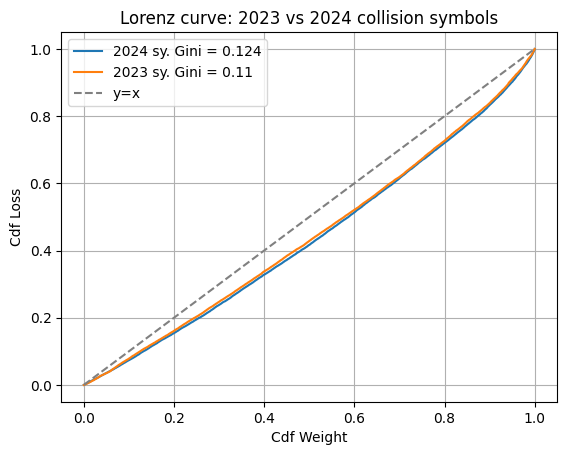

In [5]:
lrz.lorenz_curve(score_list = [ppa_symbols_data['symbol_fct_2024'], ppa_symbols_data['symbol_fct_2023_x']], 
                              weight_list = [ppa_symbols_data['adjecd_100k_xsym_norm'], ppa_symbols_data['adjecd_100k_xsym_norm']] , 
                              loss_list = [ ppa_symbols_data['loss_cap100k'],  ppa_symbols_data['loss_cap100k']], 
                              title = 'Lorenz curve: 2023 vs 2024 collision symbols', 
                              label_list = ['2024 sy', '2023 sy'])

## lift charts



/home/jovyan/workspace/SAP/exhibits/lift_bar_chart.py:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<= -15.0%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  bin.loc[score <= 1- (n_bins /2 -1)* bw ] = f'<= -{str(np.round((n_bins /2 -1) *bw*100))}%'
/home/jovyan/workspace/SAP/exhibits/lift_bar_chart.py:126: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = local.groupby('bin').sum().reset_index()
/home/jovyan/workspace/SAP/exhibits/lift_bar_chart.py:158: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(grouper['bin'], rotation=45)


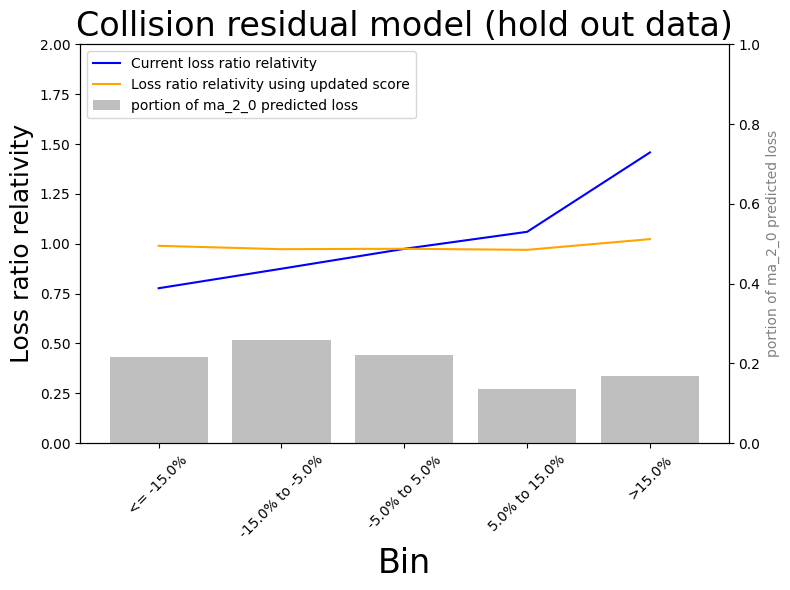

,bin,loss,pred_loss,weight,predicted_lr,pct_wt,actual_lr,updated_lr
0,<= -15.0%,63022464.51,6.369416e+07,8.114889e+07,0.784905,0.214945,0.776628,0.989454
1,-15.0% to -5.0%,85529003.97,8.795067e+07,9.780220e+07,0.899271,0.259056,0.874510,0.972466
2,-5.0% to 5.0%,81544956.05,8.366401e+07,8.370282e+07,0.999536,0.221710,0.974220,0.974672
3,5.0% to 15.0%,54073767.93,5.579154e+07,5.103264e+07,1.093252,0.135174,1.059592,0.969211
4,>15.0%,93072279.51,9.098579e+07,6.384705e+07,1.425059,0.169116,1.457738,1.022932


,bin,loss,pred_loss,weight,predicted_lr,pct_wt,actual_lr,updated_lr
0,<= -15.0%,63022464.51,6.369416e+07,8.114889e+07,0.784905,0.214945,0.776628,0.989454
1,-15.0% to -5.0%,85529003.97,8.795067e+07,9.780220e+07,0.899271,0.259056,0.874510,0.972466
2,-5.0% to 5.0%,81544956.05,8.366401e+07,8.370282e+07,0.999536,0.221710,0.974220,0.974672
3,5.0% to 15.0%,54073767.93,5.579154e+07,5.103264e+07,1.093252,0.135174,1.059592,0.969211
4,>15.0%,93072279.51,9.098579e+07,6.384705e+07,1.425059,0.169116,1.457738,1.022932


In [6]:
ppa_symbols_data['pred_loss_2024'] = ppa_symbols_data['symbol_fct_2024'] * ppa_symbols_data['adjecd_100k_xsym_norm']
import importlib
importlib.reload(lift)
lift.lift_chart(ppa_symbols_data['loss_cap100k'], 
                ppa_symbols_data['pred_loss_2024'], 
                ppa_symbols_data['adjecd_100k_xsym_norm'], 
                bin_series = pd.Series(), 
                bw = 0.1, 
                n_bins = 5)